# Load data

In [6]:
import xarray as xr

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs = xr.open_dataset(data_dir + '/ds_sat_EOFs.nc')
ds_sat_EOFs.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_std                (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float32 ...
    sat_centered_weighted  (age, lat, lon) float32 ...
    EOF1                   (lat, lon) float32 ...
    EOF2                   (lat, lon) float32 ...>

In [32]:
ds_sat_EOFs

<xarray.Dataset>
Dimensions:                (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_std                (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 4.068 4.07 ... -0.7796
    weight                 (lat) float32 0.0 0.03306 0.06609 ... 0.03306 0.0
    sat_centered_weighted  (age, lat, lon) float32 ...
    EOF1                   (lat, lon) float32 3.388e-15 -3.662e-18 ... 0.0 0.0
    EOF2                   (lat, lon) float32 -5.903e-17 1.409e-17 ... 0.0 0.0

# Plot EOFs

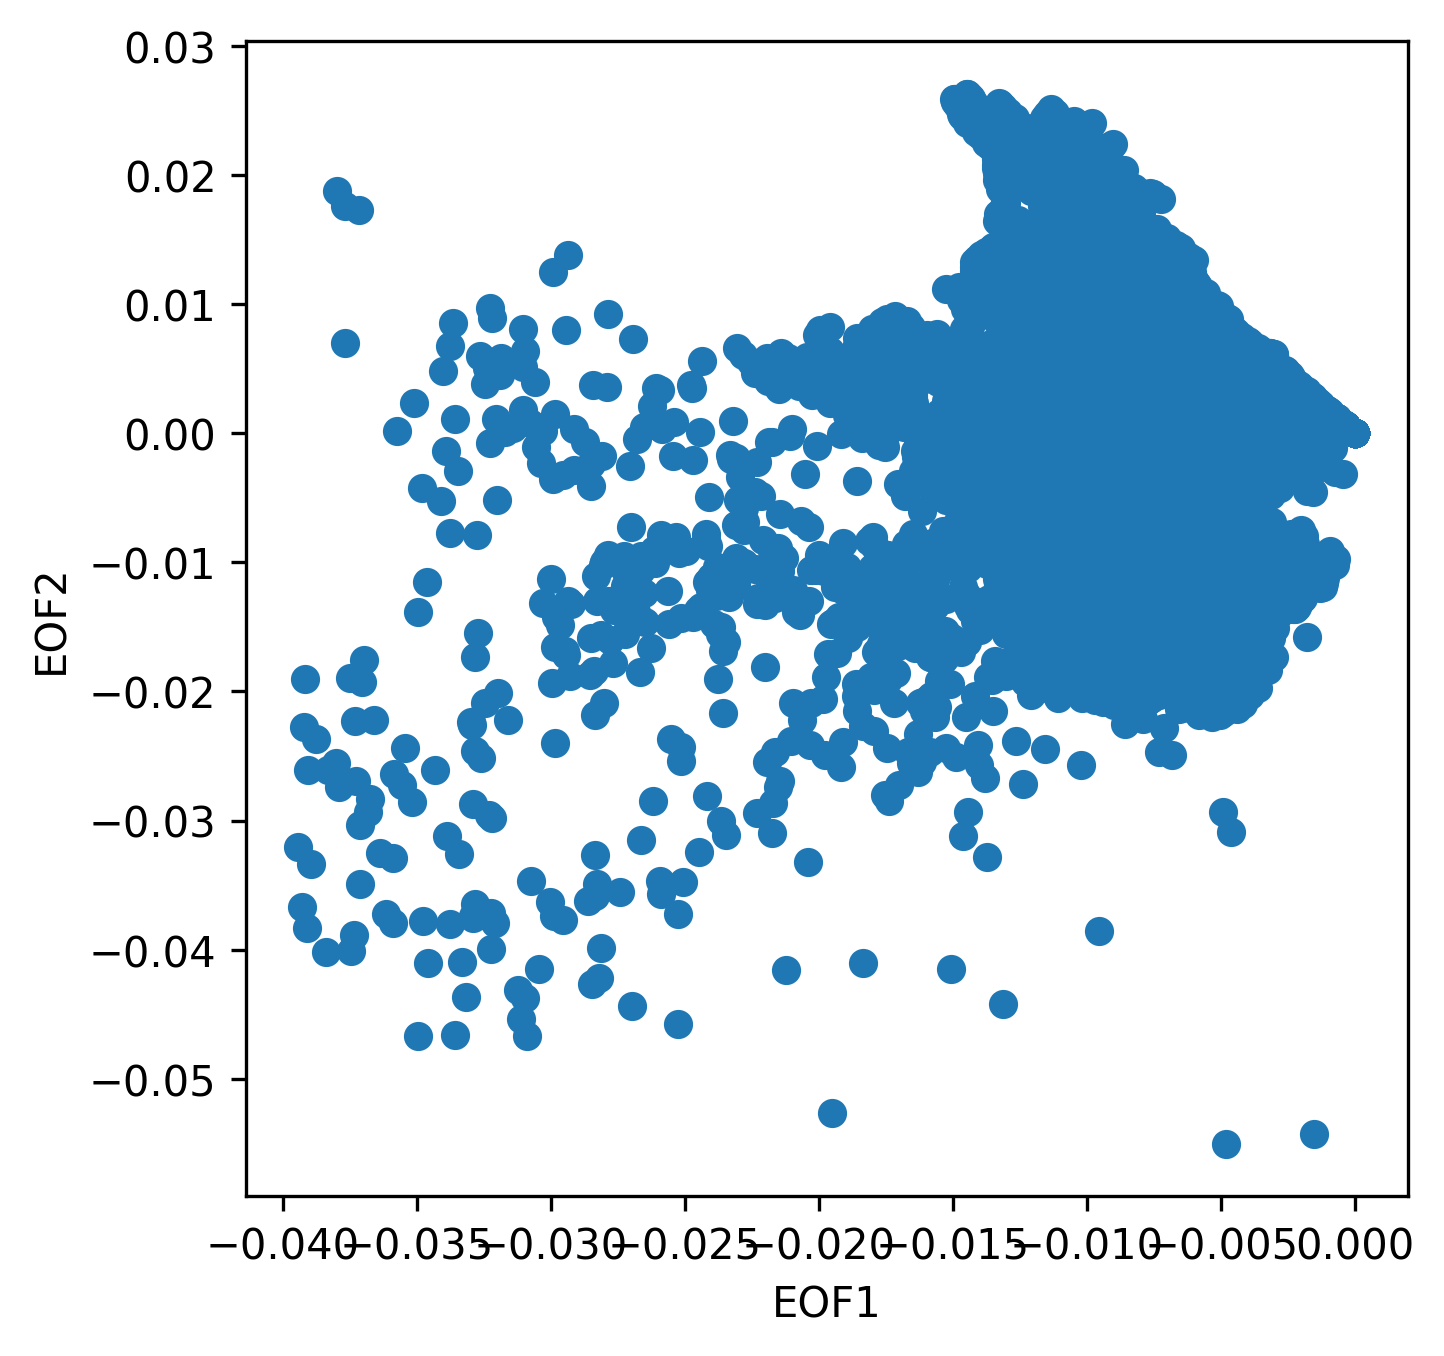

In [2]:
# plot the temp_score using 2d scatter plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
plt.scatter(ds_sat_EOFs['EOF1'].values.reshape(96*144,1), ds_sat_EOFs['EOF2'].values.reshape(96*144,1))
# add x and y labels
plt.xlabel('EOF1')
plt.ylabel('EOF2')

plt.show()

# Calculate the AIC and Determine the optimal number of classes

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Assuming ds_sat_EOFs is your xarray Dataset
eof1_data = ds_sat_EOFs['EOF1'].values.flatten()
eof2_data = ds_sat_EOFs['EOF2'].values.flatten()

# Combine the reshaped EOF1 and EOF2 data
combined_data = np.column_stack((eof1_data, eof2_data))

# Define the range of number of components and the number of iterations
n_components_range = range(2, 9)  # 2 to 8 inclusive
n_iterations = 10

aic_values_dict = {}

# Loop over the range of components
for n_components in n_components_range:
    aic_values = []
    
    # Monte Carlo iterations
    for _ in range(n_iterations):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(combined_data)
        
        # Calculate and store the AIC for this fit
        aic_values.append(gmm.aic(combined_data))
    
    # Record the AIC values for this number of components
    aic_values_dict[n_components] = aic_values



# Plot AIC and delta AIC

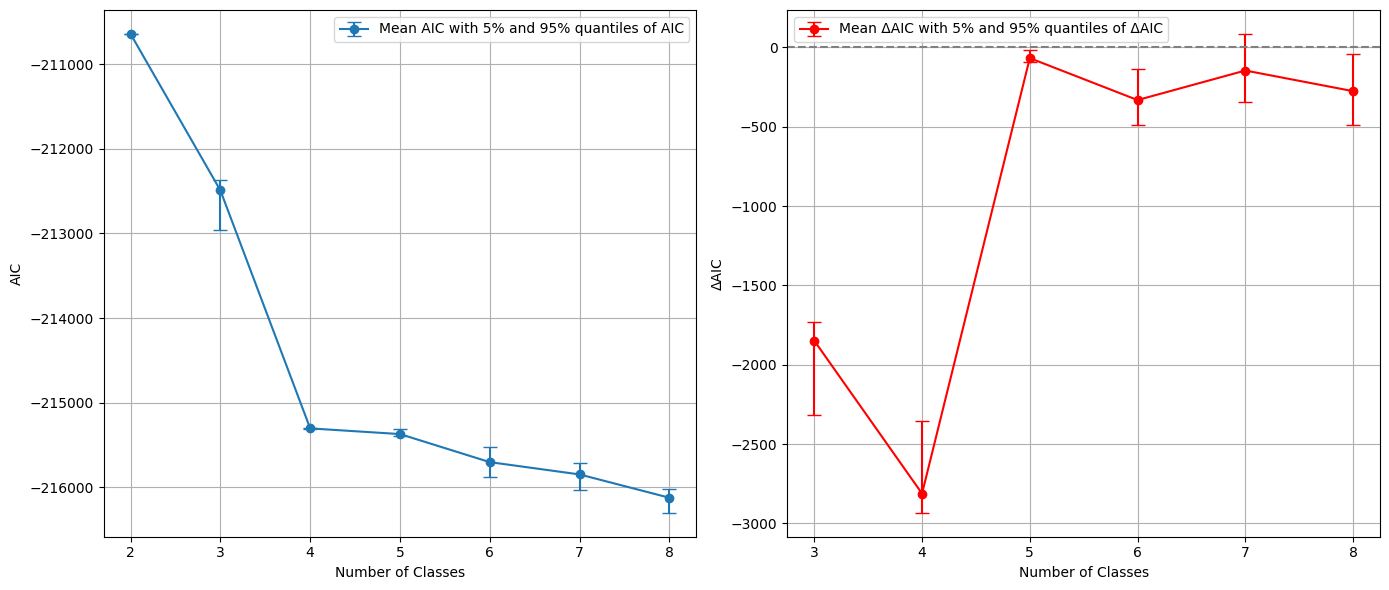

In [15]:
# Compute means, lower and upper limits
means = [np.mean(aic_values_dict[key]) for key in n_components_range]
lower_limits = [np.percentile(aic_values_dict[key], 5) for key in n_components_range]
upper_limits = [np.percentile(aic_values_dict[key], 95) for key in n_components_range]

# Differences from the mean for error bars
lower_errors = [mean - lower for mean, lower in zip(means, lower_limits)]
upper_errors = [upper - mean for mean, upper in zip(means, upper_limits)]

# Compute ΔAIC for each n_components during each Monte Carlo iteration
delta_aics_all_iterations = []
for i in range(n_iterations):
    iteration_delta_aics = np.diff([aic_values_dict[n][i] for n in n_components_range])
    delta_aics_all_iterations.append(iteration_delta_aics)

# Convert to a 2D numpy array for easier operations
delta_aics_all_iterations = np.array(delta_aics_all_iterations)

# Now, compute the mean ΔAIC and its 5% and 95% quantiles
delta_aics_means = np.mean(delta_aics_all_iterations, axis=0)
delta_aics_lowers = np.percentile(delta_aics_all_iterations, 5, axis=0)
delta_aics_uppers = np.percentile(delta_aics_all_iterations, 95, axis=0)

# Differences from the mean ΔAIC for error bars
delta_lower_errors = delta_aics_means - delta_aics_lowers
delta_upper_errors = delta_aics_uppers - delta_aics_means

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# AIC Plot
ax[0].errorbar(n_components_range, means, yerr=[lower_errors, upper_errors], 
               capsize=5, fmt='-o', label='Mean AIC with 5% and 95% quantiles of AIC')
ax[0].set_xlabel('Number of Classes')
ax[0].set_ylabel('AIC')
ax[0].legend()
ax[0].grid(True)

# ΔAIC Plot
ax[1].errorbar(n_components_range[1:], delta_aics_means, yerr=[delta_lower_errors, delta_upper_errors], 
               capsize=5, fmt='-o', color='red', label='Mean ΔAIC with 5% and 95% quantiles of ΔAIC')
ax[1].axhline(0, color='grey', linestyle='--')
ax[1].set_xlabel('Number of Classes')
ax[1].set_ylabel('ΔAIC')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Doing GMM with Monte Carlo, using sklearn for the GMM

In [7]:
import numpy as np
import xarray as xr
from sklearn.mixture import GaussianMixture

def gmm_mc_sklearn(ds_sat_EOFs, n_components=4, n_iterations=10, covariance_type='full'):
    """
    Perform Gaussian Mixture Modeling on the given xarray dataset.

    Parameters:
    - ds_sat_EOFs: xarray dataset containing EOF1 and EOF2 data.
    - n_components: number of Gaussian components for GMM. Default is 4.
    - n_iterations: number of iterations for the Monte Carlo method. Default is 10.
    - covariance_type: type of covariance parameters to use. Default is 'full'.

    Returns:
    - results: a list containing the label assignments for each iteration.
    """

    # 1. Reshape the EOF1 and EOF2 data
    eof1_data = ds_sat_EOFs['EOF1'].values.flatten()
    eof2_data = ds_sat_EOFs['EOF2'].values.flatten()

    # 2. Combine the reshaped EOF1 and EOF2 data
    combined_data = np.column_stack((eof1_data, eof2_data))
    results = []

    # 3. For each iteration, fit a GMM
    for _ in range(n_iterations):
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        gmm.fit(combined_data)
        labels = gmm.predict(combined_data)
        
        # Store results for each iteration
        results.append({
            'labels': labels,
        })
    
    return results


In [8]:
results_sklearn=gmm_mc_sklearn(ds_sat_EOFs, n_components=4, n_iterations=100)

# Doing GMM with Monte Carlo, useing a user function

Ref: https://brilliant.org/wiki/gaussian-mixture-model/

The structure of the covariances when there are two fearures (dimensions):\
| var(feature1)   cov(feature1, feature2) |\
| cov(feature2, feature1)   var(feature2) |


In [9]:
import numpy as np
from sklearn.cluster import KMeans

def initialize_parameters(data, n_components, init_params='kmeans'):
    n, _ = data.shape # data with the size (n_samples, n_features)
    weights = np.ones(n_components) / n_components

    # Initializing means based on the value of init_params
    if init_params == 'kmeans':
        kmeans = KMeans(n_clusters=n_components,n_init='auto')
        kmeans.fit(data)
        means = kmeans.cluster_centers_
    elif init_params == 'random_from_data':
        means = data[np.random.choice(n, n_components, replace=False)]
    else:
        raise ValueError("Invalid value for init_params. Choose 'kmeans' or 'random_from_data'.")

    covariances = [np.cov(data, rowvar=False) for _ in range(n_components)]  # 'rowvar=False': each row represents an observation, and each column represents a variable


    # if covariance_type == 'full':
    #     covariances = [np.cov(data, rowvar=False) for _ in range(n_components)]
    
    # elif covariance_type == 'diag':
    #     diag_cov = np.diag(np.diag(np.cov(data, rowvar=False)))
    #     covariances = [diag_cov for _ in range(n_components)]
    # else:
    #     raise ValueError("Invalid covariance type")

    return weights, means, covariances


def e_step(data, weights, means, covariances):
    n, _ = data.shape
    n_components = len(weights)
    posterior_probab = np.zeros((n, n_components))
    
    for i in range(n_components):
        # The GMM from sklearn by default using k-mean to initialize the the posterior_probab (they call it responsibilities)
        posterior_probab[:, i] = weights[i] * multivariate_gaussian(data, means[i], covariances[i])
        
    
    posterior_probab /= posterior_probab.sum(axis=1, keepdims=True)
    # print(posterior_probab.shape)
    return posterior_probab

def m_step(data, posterior_probab):
    n, d = data.shape
    _,n_components = posterior_probab.shape
    
    weights = np.zeros(n_components)
    means = np.zeros((n_components, d))
    covariances = np.zeros((n_components, d, d))
    
    for i in range(n_components):
        prob_sum = posterior_probab[:, i].sum()
        weights[i] = prob_sum / n
        means[i] = (data * posterior_probab[:, i].reshape(-1, 1)).sum(axis=0) / prob_sum
        diff = (data - means[i]).T
        # covariances[i] = np.dot(diff, diff.T * posterior_probab[:, i].reshape(-1, 1)) / prob_sum
        # As the GMM in sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html), 
        # here, a Non-negative regularization to the diagonal of covariance. Allows to assure that the covariance matrices are all positive.
        covariances[i] = np.dot(diff, diff.T * posterior_probab[:, i].reshape(-1, 1)) / prob_sum + np.eye(d) * 1e-6
        # reg_covar (default=1e-6 in sklearn GMM): this Non-negative regularization could affect the result
    
    return weights, means, covariances

def multivariate_gaussian(data, mean, covariance):
    n, d = data.shape
    diff = data - mean
    inv_covariance = np.linalg.inv(covariance)
    det_covariance = np.linalg.det(covariance)
    coefficient = 1.0 / np.sqrt((2 * np.pi) ** d * det_covariance)
    exponential = np.exp(-0.5 * np.sum(np.dot(diff, inv_covariance) * diff, axis=1))
    return coefficient * exponential

def compute_log_likelihood(data, weights, means, covariances):
    n_components = len(weights)
    total_likelihood = np.zeros(data.shape[0])
    for i in range(n_components):
        total_likelihood += weights[i] * multivariate_gaussian(data, means[i], covariances[i])
    return np.sum(np.log(total_likelihood))


import numpy as np

def gmm_mc_user(ds_sat_EOFs, n_components=4, n_iterations=100, em_iterations=1000, tol=1e-6):
    """
    Perform Gaussian Mixture Modeling using a self-defined approach and Monte Carlo method.

    Parameters:
    - ds_sat_EOFs: xarray dataset containing EOF1 and EOF2 data.
    - n_components: number of Gaussian components for GMM. Default is 4.
    - n_iterations: number of iterations for the Monte Carlo method. Default is 1000.
    - em_iterations: number of iterations for the EM algorithm. Default is 100.
    - tol: convergence threshold. EM iterations will stop when the difference in log-likelihood is below this threshold. Default is 1e-6.

    Returns:
    - results: a list containing the label assignments for each iteration.
    """

    # 1. Reshape the EOF1 and EOF2 data
    eof1_data = ds_sat_EOFs['EOF1'].values.flatten()
    eof2_data = ds_sat_EOFs['EOF2'].values.flatten()

    # 2. Combine the reshaped EOF1 and EOF2 data
    combined_data = np.column_stack((eof1_data, eof2_data))

    results = []

    for _ in range(n_iterations):
        # Initialize the parameters
        weights, means, covariances = initialize_parameters(combined_data, n_components)

        prev_log_likelihood = -np.inf

        for _ in range(em_iterations):
            responsibilities = e_step(combined_data, weights, means, covariances)
            weights, means, covariances = m_step(combined_data, responsibilities)
            
            # Check for convergence
            current_log_likelihood = compute_log_likelihood(combined_data, weights, means, covariances)
            if (current_log_likelihood - prev_log_likelihood) < tol:
                break
            prev_log_likelihood = current_log_likelihood

        # Assign each data point to the cluster with maximum responsibility
        labels = np.argmax(responsibilities, axis=1)
        
        results.append({
            'labels': labels,
        })

    return results


In [10]:
results_user=gmm_mc_user(ds_sat_EOFs, n_components=4, n_iterations=100)

# Align labels accross iterations using methods in M. Osman's MATLAB code

In [11]:
import numpy as np

def align_labels4two_iters(reference_labels, labels_to_align):
    unique_ref_labels = np.unique(reference_labels)
    unique_align_labels = np.unique(labels_to_align)
    
    n_classes_ref = len(unique_ref_labels)
    n_classes_align = len(unique_align_labels)

    # Ensure the number of unique classes is the same in both label sets
    if n_classes_ref != n_classes_align:
        raise ValueError("The number of unique classes in the reference and labels to align must be the same.")

    n_classes = n_classes_ref

    # Create a mapping based on overlap
    mapping = {}
    for ref_label in unique_ref_labels:
        overlaps = [] # for each ref_label, calculate the sum of overlap with each align_label
        for align_label in unique_align_labels:
            overlap = np.sum((labels_to_align == align_label) & (reference_labels == ref_label))
            overlaps.append(overlap)

        # Get the align label with the max overlap for the current reference label
        max_overlap_label = unique_align_labels[np.argmax(overlaps)]
        
        if max_overlap_label in mapping.values():
            # Handle the situation where a label has already been mapped due to identical overlaps
            # For example, for two ref_labels, they corresponds to the same align_label
            available_labels = list(set(unique_align_labels) - set(mapping.values())) # find the labels in unique_align_labels that have not been mapped
            overlaps_available = [overlaps[i] for i in range(n_classes) if unique_align_labels[i] in available_labels]
            max_overlap_label = available_labels[np.argmax(overlaps_available)]

        mapping[ref_label] = max_overlap_label

    # Apply the mapping to the labels_to_align array
    aligned_labels = np.copy(labels_to_align)
    for ref, align in mapping.items():
        aligned_labels[labels_to_align == align] = ref

    return aligned_labels


def align_labels(results):
    n_iterations=len(results)
    reference_labels = results[0]['labels']
    for i in range(1, n_iterations):
        aligned_labels = align_labels4two_iters(reference_labels, results[i]['labels'])
        results[i]['labels'] = aligned_labels
    return results


In [12]:
results_sklearn=align_labels(results_sklearn)
results_user=align_labels(results_user)


# Save the results

In [10]:
# store the results to a csv
data_dir = 'D:/VScode/Last_deglaciation/data'

import pickle

with open('D:/VScode/Last_deglaciation/data/results_overlap_al.pkl', 'wb') as f:
    pickle.dump(results, f)




In [26]:
# import the results
import pickle
with open('D:/VScode/Last_deglaciation/data/results_overlap_al.pkl', 'rb') as f:
    results = pickle.load(f)



# Plot label distributions in maps of the first 10 iterations

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_labels_on_axes(ds, ax):
    sat_label = ds['class_label']

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # add coastline and gridlines
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines()

    # create colormap with unique colors for each class label
    cmap = mcolors.ListedColormap(colors[0:len(np.unique(sat_label))])

    im = ax.pcolormesh(ds.lon, ds.lat, sat_label, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto')
    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Iteration: {ds.iteration.item()}')

    # add colorbar
    bounds = np.arange(len(np.unique(sat_label))+1) - 0.5
    ticks = np.arange(len(np.unique(sat_label)))
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, boundaries=bounds, ticks=ticks, shrink=0.3)

    cbar.ax.set_yticklabels(np.unique(sat_label))
    cbar.ax.set_ylabel('Class Label')

def plot_map_mc(ds_sat_EOFs, results, max_plots=10):
    """
    Plots class labels on a map based on Monte Carlo iterations for GMM results.
    
    Parameters:
    - ds_sat_EOFs: xarray Dataset containing EOF1 and EOF2 data.
    - results: List of dictionaries containing GMM results.
    - max_plots: Maximum number of results to plot (default is 10).
    """


    results_sampled = results[:max_plots]

    # Decide number of rows based on length of results_sampled
    n_rows = int(np.ceil(len(results_sampled) / 2))

    # Generate plots
    fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(20, 5 * n_rows), dpi=300,
                             subplot_kw=dict(projection=ccrs.PlateCarree()))

    # Ensure axes is always 2D for consistent indexing
    if n_rows == 1:
        axes = np.array([axes])

    lats = ds_sat_EOFs['lat'].values
    lons = ds_sat_EOFs['lon'].values

    for idx, result in enumerate(results_sampled):
        ds_temp = xr.Dataset({
            'class_label': (['lat', 'lon'], result['labels'].reshape(len(lats), len(lons))),
            'lat': (['lat'], lats),
            'lon': (['lon'], lons),
            'iteration': idx + 1
        })
        ax = axes[idx // 2, idx % 2]
        plot_labels_on_axes(ds_temp, ax)

    plt.tight_layout()
    plt.show()

# Plot the first 10 results of the MC, for GMM using sklearn

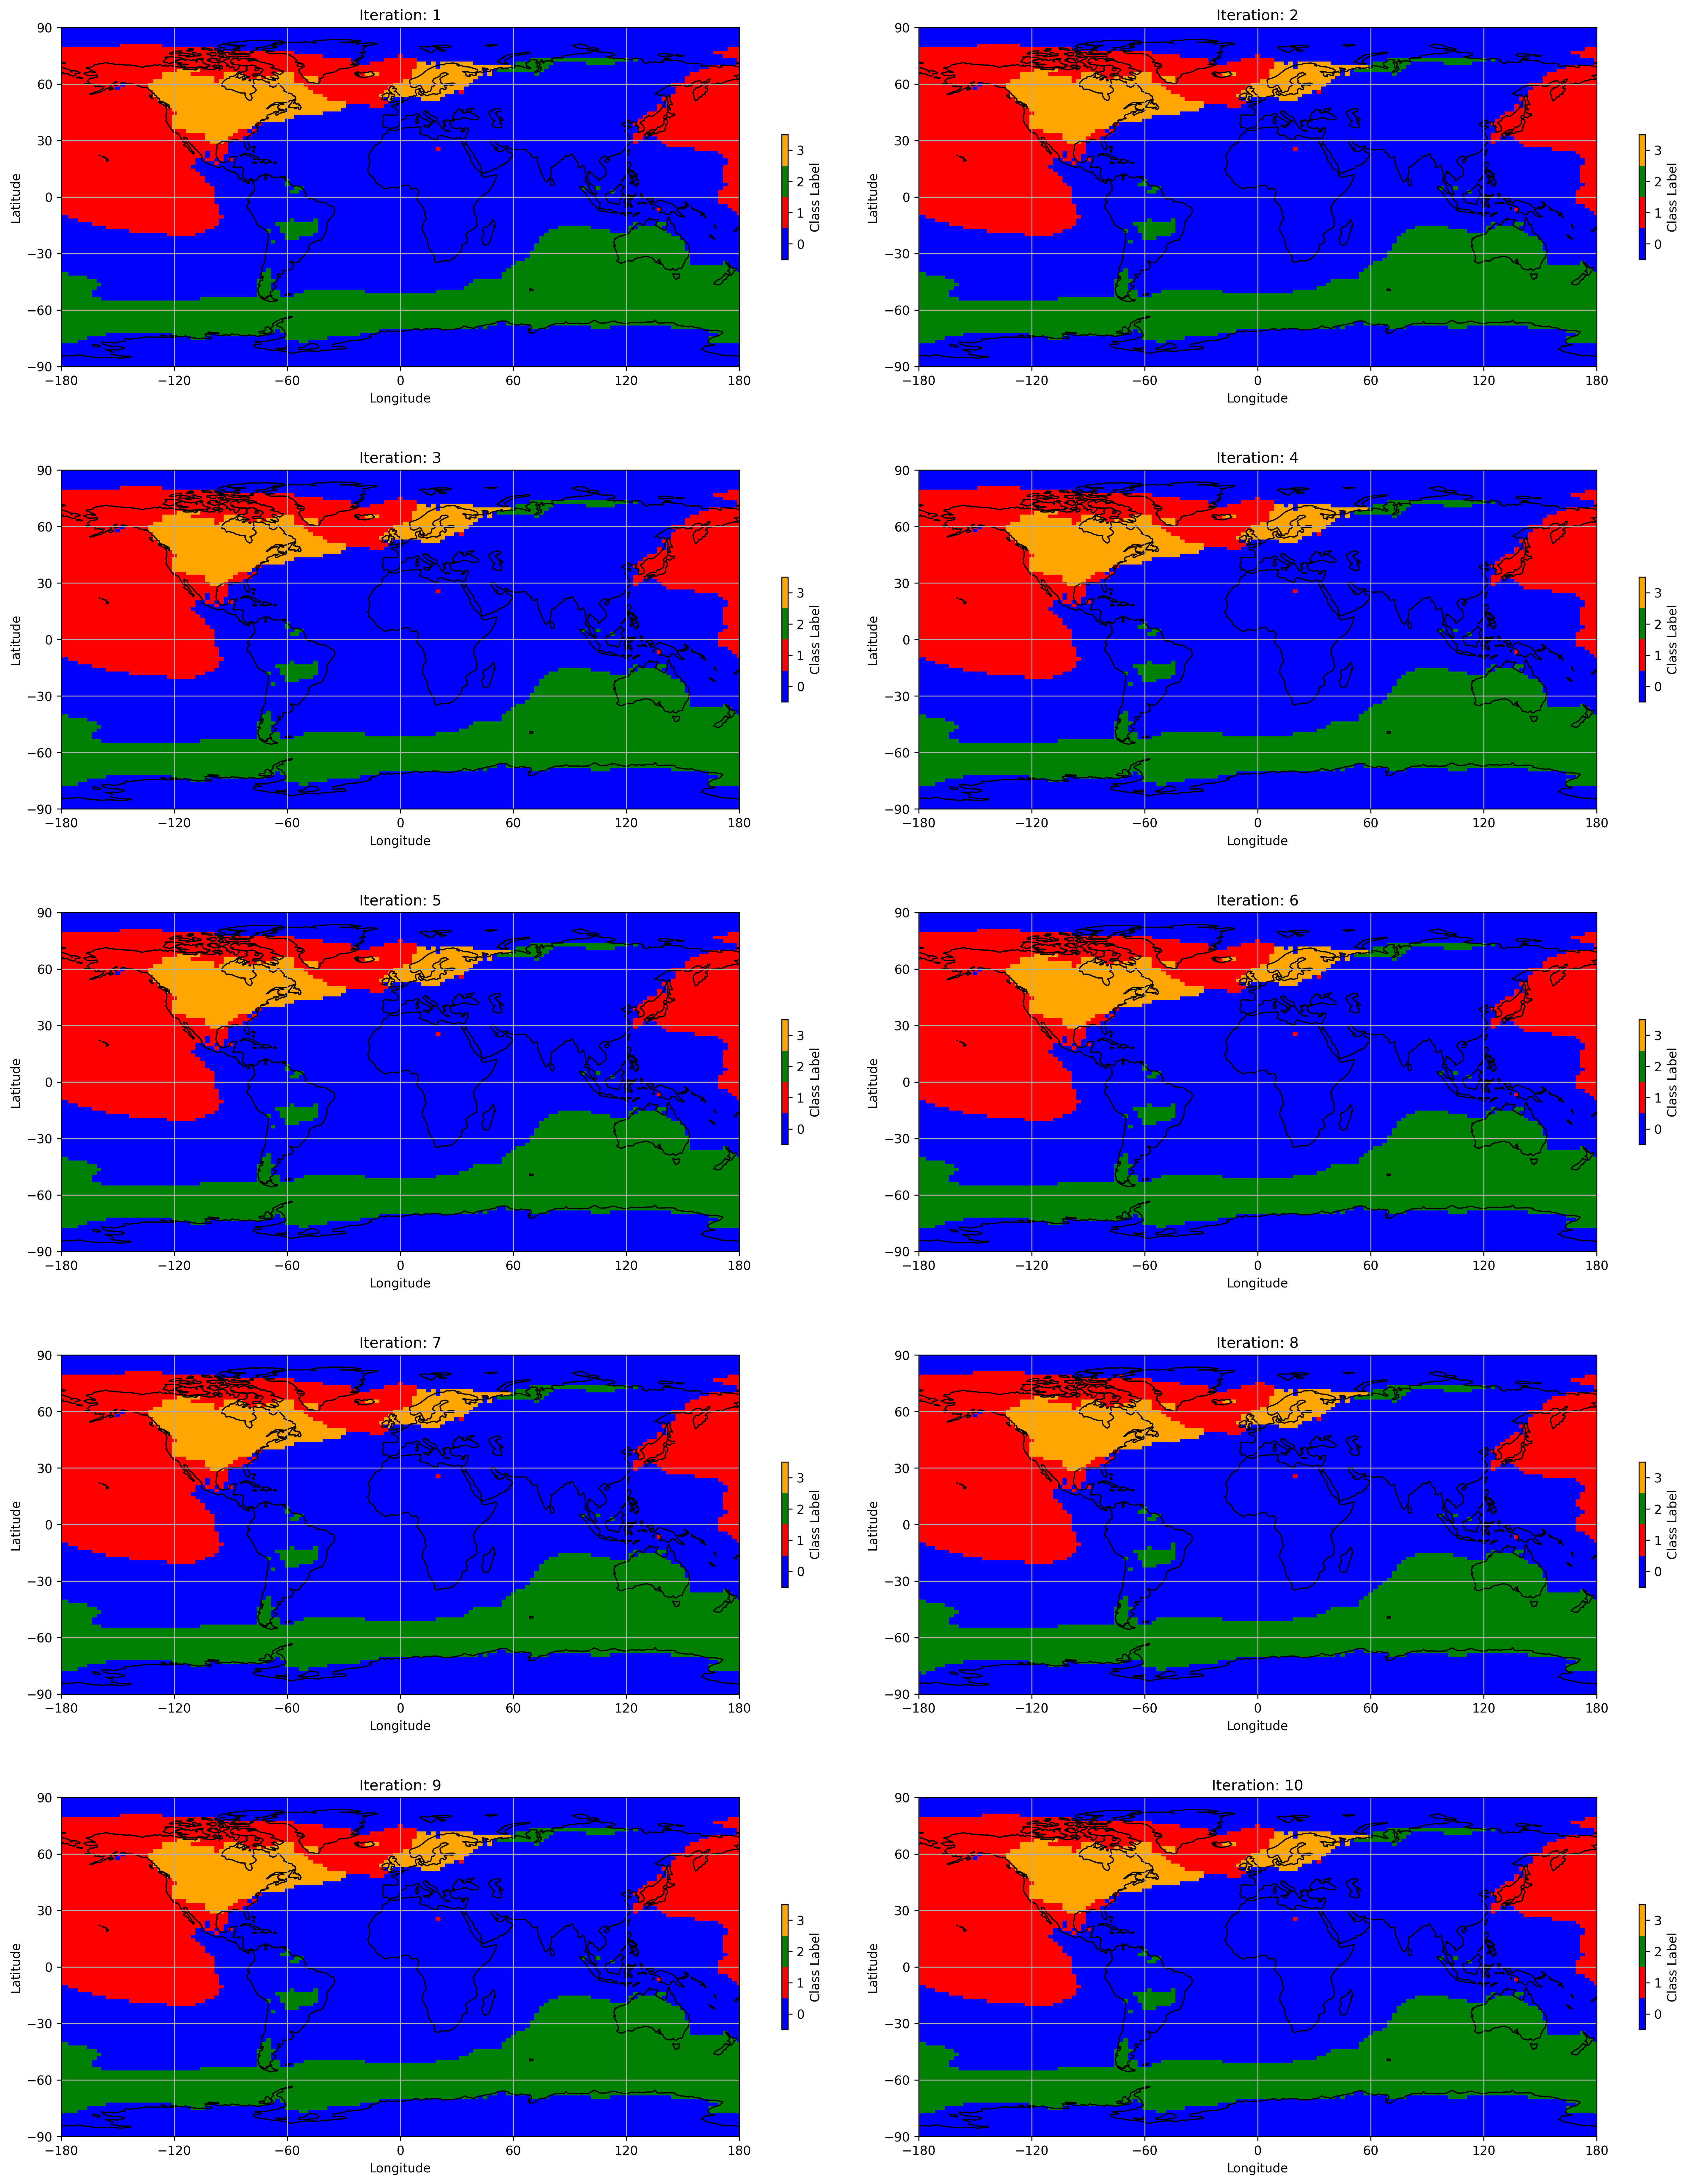

In [14]:
plot_map_mc(ds_sat_EOFs, results_sklearn, max_plots=10)

# Plot the first 10 results of the MC, for GMM using user function

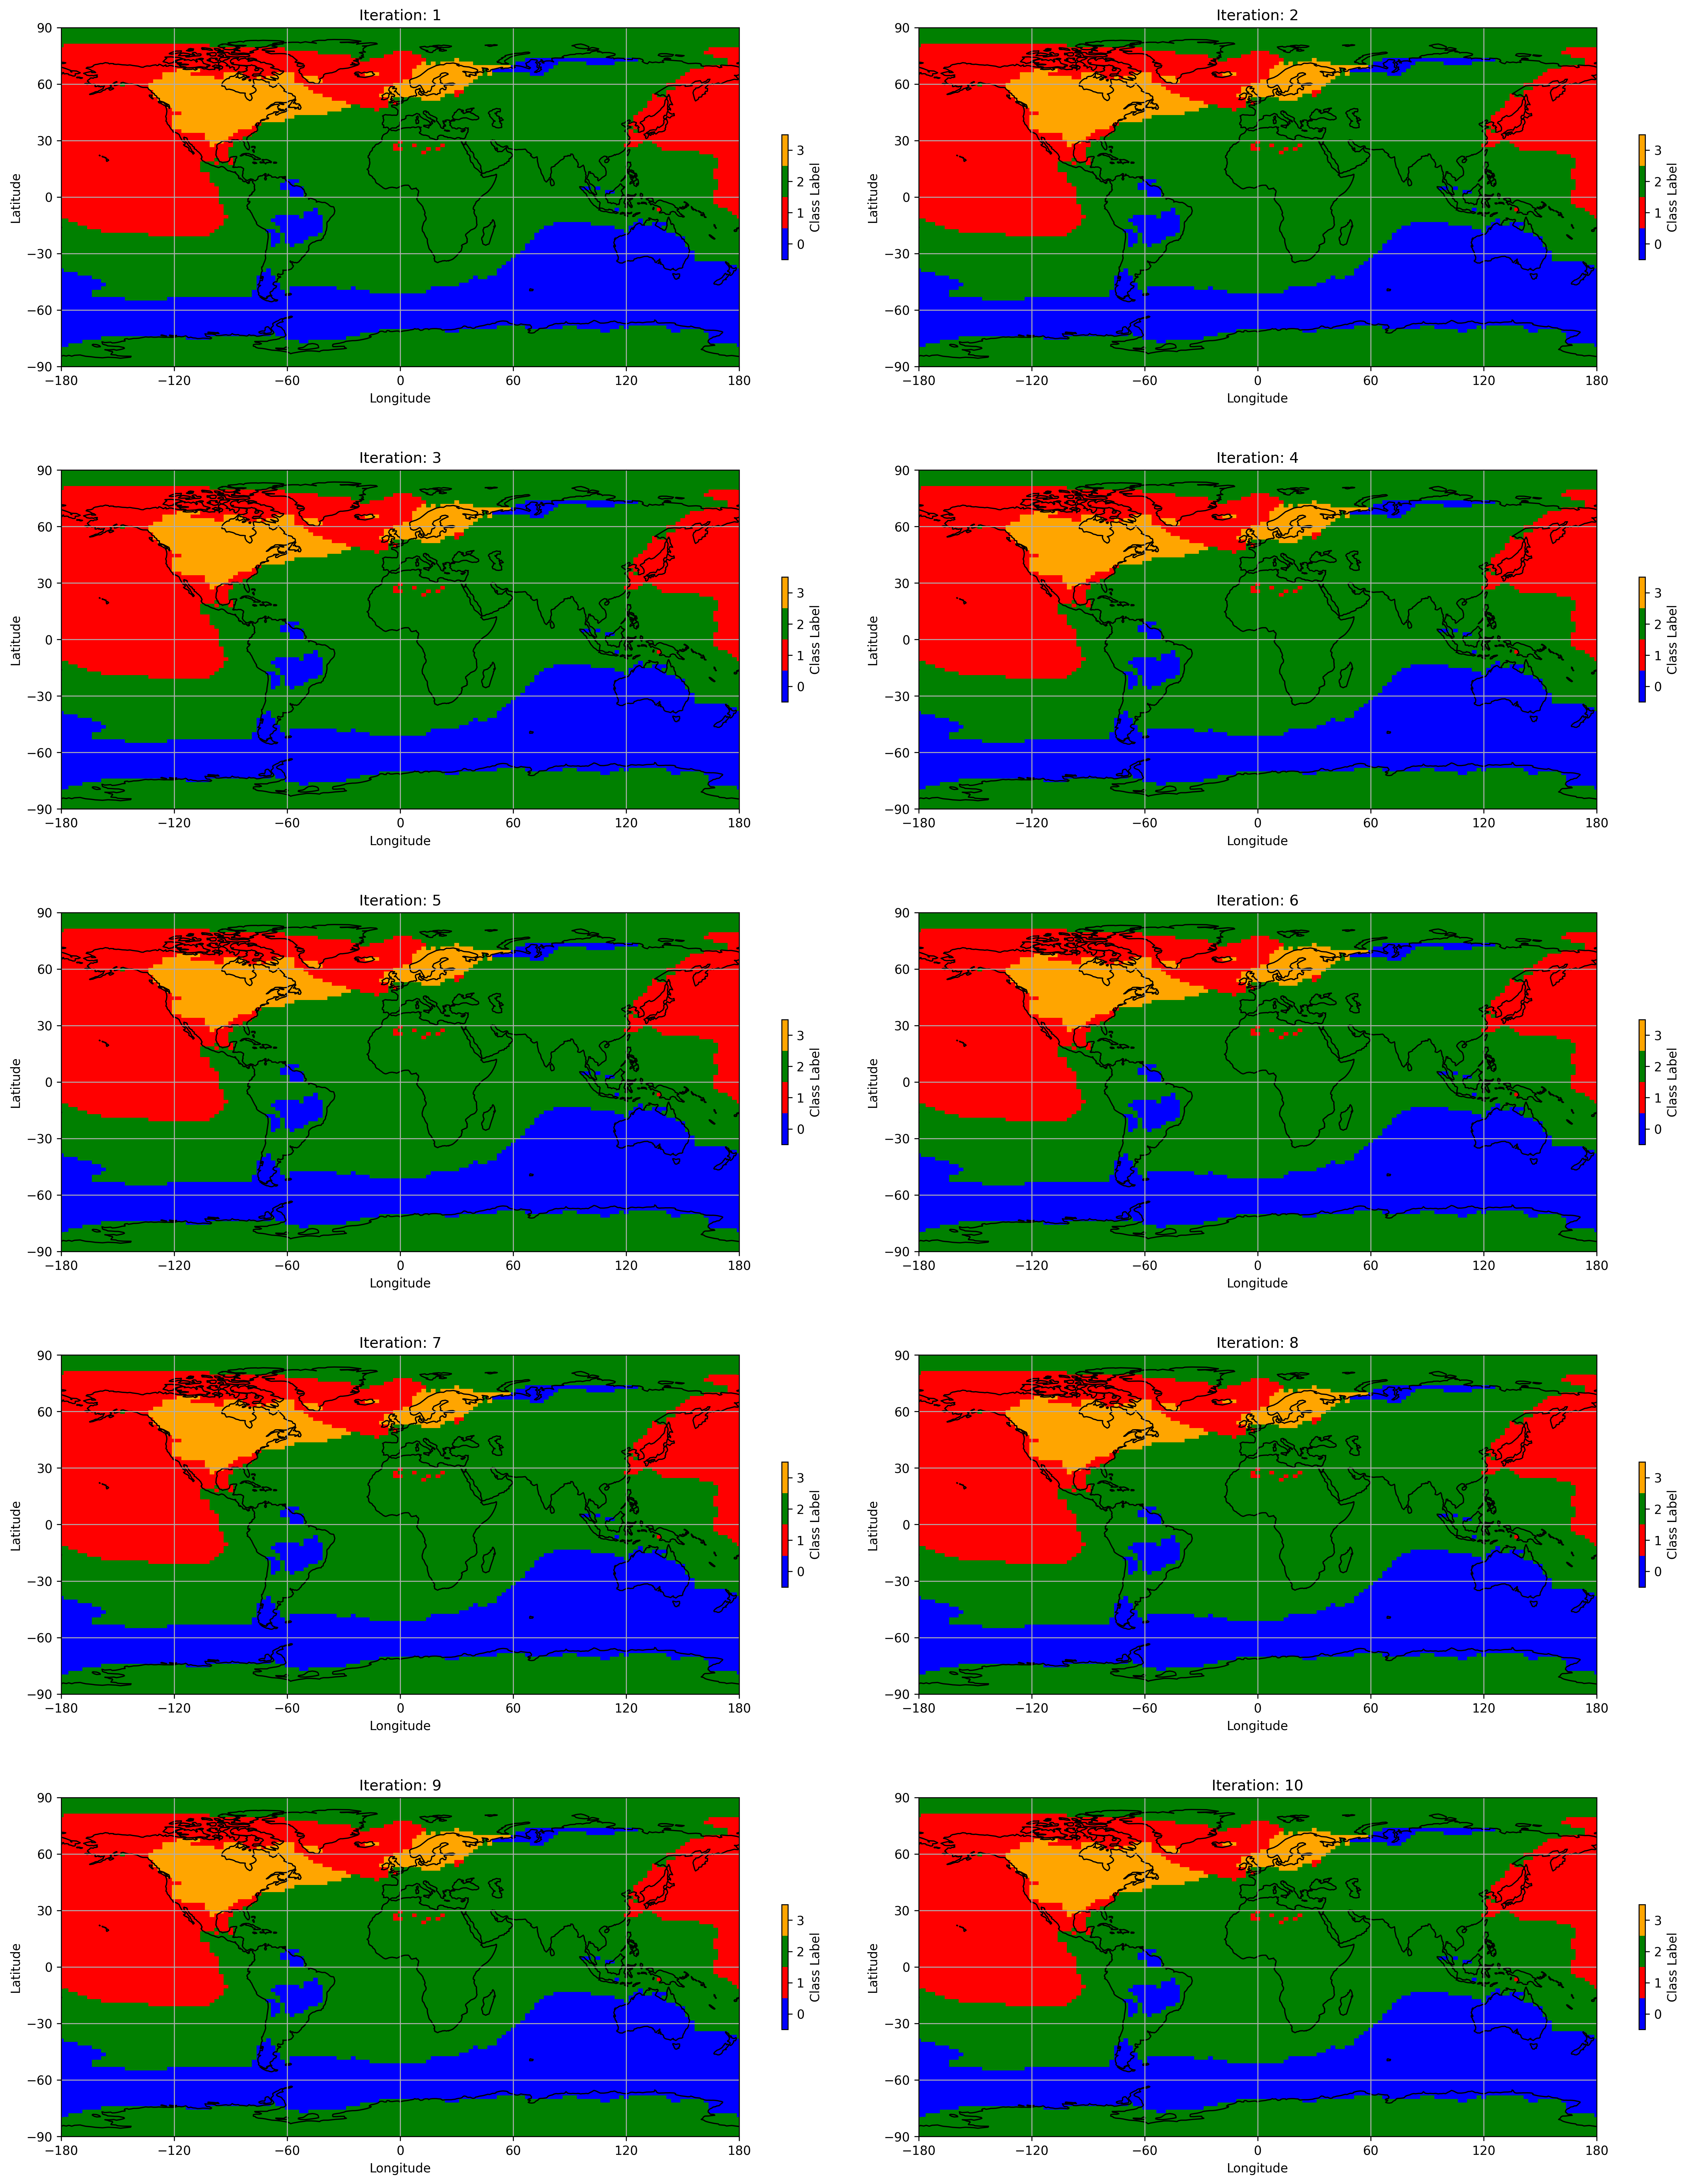

In [15]:
plot_map_mc(ds_sat_EOFs, results_user, max_plots=10)

# Get the age of termination initiation of each class for each iteration

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def find_T_ini_age(ds_sat_EOFs, results, check_plot=False, print_shape=False):
    """
    Find the age corresponding to the minimum of the weighted mean curve of each class for all iterations.
    
    Parameters:
    - ds_sat_EOFs: xarray Dataset containing satellite data.
    - results: List of dictionaries containing GMM results.
    - check_plot: Boolean, if True will plot the first iteration's weighted and unweighted mean curves.

    Returns:
    - min_ages_all_iter: List of ages corresponding to the minimum of the weighted mean curve for all iterations.
    - class_label_all_iter: List of class labels for all iterations.
    """
    
    # 1. Extract the sat_centered data and extend weights
    sat_centered_data = ds_sat_EOFs['sat_centered'].values
    weights = ds_sat_EOFs['weight'].values
    ages = ds_sat_EOFs['age'].values

    # Reshape weights to have a shape of (number of latitudes, 1) and then broadcast it across all longitudes
    weights_broadcasted = weights[:, np.newaxis] * np.ones(ds_sat_EOFs['lon'].shape[0])
    

    
    min_ages_all_iter = []
    class_label_all_iter = []
    
    j = 0
    for result in results:
        labels = result['labels'].reshape(ds_sat_EOFs['lat'].shape[0], ds_sat_EOFs['lon'].shape[0])
        min_ages = []
        class_label_pre_iter = []
        
        for class_label in np.unique(labels):  # the np.unique returns the sorted values
            class_label_pre_iter.append(class_label)
            data_for_class = sat_centered_data[:, labels == class_label]
            weights_for_class = weights_broadcasted[labels == class_label]
            # weights_for_class = weights_broadcasted[labels == class_label].flatten()
            
            weighted_sum_of_class = np.sum(data_for_class * weights_for_class, axis=1)
            if print_shape:
                print('shape of data_for_class: ', data_for_class.shape)
                print('shape of weights_for_class: ', weights_for_class.shape)
                print('shape of weighted_sum_of_class: ', weighted_sum_of_class.shape)

            total_weights = np.sum(weights_for_class)
            weighted_mean_curve = weighted_sum_of_class / total_weights
            
            if check_plot and j == 0:
                plt.plot(ages, weighted_mean_curve, label='weighted mean {}'.format(class_label))
                plt.plot(ages, np.mean(data_for_class, axis=1), label='Unweighted mean {}'.format(class_label))
                plt.legend()
                plt.xlabel('Age (years)')
                plt.ylabel('weighted mean curve of the class') 
                j += 1
                
            min_age_for_class = ages[np.argmin(weighted_mean_curve)]
            min_ages.append(min_age_for_class)
        
        min_ages_all_iter.append(min_ages)
        class_label_all_iter.append(class_label_pre_iter)
        
        
    
    if check_plot:
        plt.show()
        
    return min_ages_all_iter, class_label_all_iter



In [30]:

min_ages_sklearn, _ = find_T_ini_age(ds_sat_EOFs, results_sklearn)
min_ages_user,_= find_T_ini_age(ds_sat_EOFs, results_user)

# Save the searched deglaciation start time

In [31]:

import pickle

with open('D:/VScode/Last_deglaciation/data/min_ages_all_iter.pkl', 'wb') as f:
    pickle.dump(min_ages_all_iter, f)




In [ ]:
with open('D:/VScode/Last_deglaciation/data/min_ages_all_iter.pkl', 'rb') as f:
    min_ages_all_iter = pickle.load(f)

# Calculate the distribution of termination initiation

In [31]:
def print_T_ini_age_dist(min_ages_all_iter):
    """
    Print the distribution of ages corresponding to the minimum of the weighted mean curve for each class.
    
    Parameters:
    - min_ages_all_iter: List of ages corresponding to the minimum of the weighted mean curve for all iterations.
    """
    
    # Transpose the list for easier column access
    transposed_min_ages = list(zip(*min_ages_all_iter))

    # Loop through each class
    for class_idx, ages_for_class in enumerate(transposed_min_ages):
        print(f"Class {class_idx}:")

        # Find unique ages and their counts
        unique_ages, counts = np.unique(ages_for_class, return_counts=True)

        # Calculate and print the percentage for each unique age
        for age, count in zip(unique_ages, counts):
            percentage = (count / len(ages_for_class)) * 100
            print(f"Age: {age}, Percentage: {percentage:.2f}%")

        print("-" * 30)  # Separator for better visibility


In [32]:
print_T_ini_age_dist(min_ages_sklearn)

Class 0:
Age: 17700.0, Percentage: 100.00%
------------------------------
Class 1:
Age: 17100.0, Percentage: 100.00%
------------------------------
Class 2:
Age: 21100.0, Percentage: 100.00%
------------------------------
Class 3:
Age: 17900.0, Percentage: 100.00%
------------------------------


In [34]:
print_T_ini_age_dist(min_ages_user)

Class 0:
Age: 21100.0, Percentage: 100.00%
------------------------------
Class 1:
Age: 17100.0, Percentage: 100.00%
------------------------------
Class 2:
Age: 17700.0, Percentage: 100.00%
------------------------------
Class 3:
Age: 17900.0, Percentage: 100.00%
------------------------------
